In [1]:
%matplotlib inline
from fastai.vision import *
from fastai.callbacks import *
from torchvision.utils import make_grid

In [2]:
mnist_data = (ImageList.from_folder(untar_data(URLs.MNIST), convert_mode='L')
                       .split_by_folder('training', 'testing')
                       .label_from_folder()
                       .databunch())

# Utils

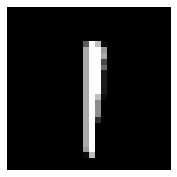

In [3]:
digit = mnist_data.train_ds.x[23181]
digit.show(cmap='gray')

In [4]:
n_degs = 19
degs = torch.linspace(0, 180, n_degs)
rot_digits = torch.stack([digit.clone().rotate(r).data for r in degs]).cuda()
rot_digits.shape

torch.Size([19, 1, 28, 28])

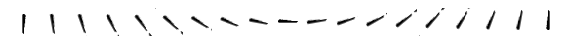

In [5]:
degs_img = 1 - make_grid(rot_digits, n_degs)
show_image(degs_img, figsize=(10,4));

# Softmax Model

In [45]:
class LeNet(nn.Sequential):
    def __init__(self):
        layers = [conv_layer(1, 20, norm_type=None), nn.MaxPool2d(2),
                  conv_layer(20, 50, norm_type=None), nn.MaxPool2d(2),
                  Flatten(), nn.Linear(2450, 500), nn.ReLU(True), nn.Dropout(0.5), nn.Linear(500,10)]
        super().__init__(*layers)
        
softmax_model = LeNet().cuda()

In [46]:
xb,yb = mnist_data.one_batch(cpu=False, denorm=False)

In [47]:
with torch.no_grad(), Hooks(softmax_model.children(), lambda m,i,o: print(o.shape)) as hooks:
    print(xb.shape)
    yb_ = softmax_model.eval()(xb)

torch.Size([64, 1, 28, 28])
torch.Size([64, 20, 28, 28])
torch.Size([64, 20, 14, 14])
torch.Size([64, 50, 14, 14])
torch.Size([64, 50, 7, 7])
torch.Size([64, 2450])
torch.Size([64, 500])
torch.Size([64, 500])
torch.Size([64, 500])
torch.Size([64, 10])


In [48]:
softmax_learner = Learner(mnist_data, softmax_model, metrics=accuracy)

In [49]:
# softmax_learner.fit(5, 1e-3)
# softmax_learner.save('softmax_model')
softmax_learner.load('softmax_model');

epoch,train_loss,valid_loss,accuracy,time
0,0.078996,0.041884,0.985400,00:13
1,0.052608,0.032616,0.988600,00:14
2,0.037981,0.029217,0.990400,00:14
3,0.037719,0.028680,0.990500,00:15
4,0.028377,0.036151,0.990300,00:12


In [50]:
yb_,yb = softmax_learner.get_preds()
accuracy(yb_,yb)

tensor(0.9903)

In [51]:
with torch.no_grad(): yb_ = softmax_model.eval()(rot_digits)

In [52]:
pred = F.softmax(yb_, dim=1)
lbls = pred.sum(0).topk(3)[1]
lp = pred[:,lbls]
lbls

tensor([1, 2, 5], device='cuda:0')

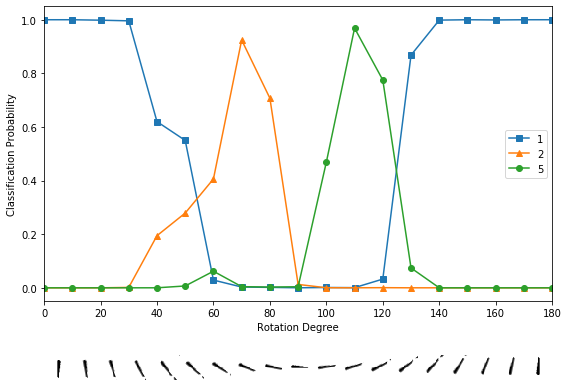

In [53]:
fig,axs = plt.subplots(2, 1, figsize=(8,6), gridspec_kw={'height_ratios': [3, 1]})

for i,m in zip(range_of(lbls),['s','^','o']*10): axs[0].plot(degs, lp[:,i], marker=m)
axs[0].legend(lbls.tolist())
axs[0].set_xlim([0,180])  
axs[0].set_xlabel('Rotation Degree')
axs[0].set_ylabel('Classification Probability')

show_image(degs_img, ax=axs[1])
plt.tight_layout()

# Uncertainty Model

Using the Expected Mean Square Error (Eq. 5 in https://arxiv.org/abs/1806.01768)

In [63]:
class LeNet(nn.Sequential):
    def __init__(self):
        layers = [conv_layer(1, 20, norm_type=None), nn.MaxPool2d(2),
                  conv_layer(20, 50, norm_type=None), nn.MaxPool2d(2),
                  Flatten(), nn.Linear(2450, 500), nn.ReLU(True), nn.Dropout(0.5), nn.Linear(500,10)]
        super().__init__(*layers)
        
class LossEq5(nn.Module):
    def __init__(self, learn:Learner):
        super().__init__()
        self.k = learn.data.c
        self.annealing_step = 5 * len(learn.data.train_dl) # 5 * number of batches in train data
        self.step = 0 # number of training steps (controlled by StepCallback)
        self.get_evidence = nn.ReLU(True)
        self.metric_names = ['log_ll', 'kl_reg']
    
    def kl(self, alpha:Tensor)->Rank0Tensor:
        beta = torch.ones(1,self.k).to(alpha.device)
        S_alpha = alpha.sum(dim=1, keepdim=True)
        loss = (alpha-beta).mul(torch.digamma(alpha)-torch.digamma(S_alpha)).sum(dim=1, keepdim=True) +\
               torch.lgamma(S_alpha) - torch.lgamma(alpha).sum(dim=1, keepdim=True) +\
               torch.lgamma(beta).sum(dim=1, keepdim=True) - torch.lgamma(beta.sum(dim=1, keepdim=True))
        anneal = min(1.0, self.step/self.annealing_step)
        return loss.view(-1).mul(anneal).mean()
    
    def forward(self, input:Tensor, target:Tensor)->Rank0Tensor:
        target = torch.eye(self.k).to(input.device)[target] # 1 hot encoding
        evidence = self.get_evidence(input)
        alpha = evidence.add(1)
        S = alpha.sum(dim=1, keepdim=True)
        log_ll = (target-alpha.div(S)).pow(2).sum(dim=1) + alpha.mul(S-alpha).div(S*S*S.add(1)).sum(dim=1)
        log_ll = log_ll.mean()
        kl_reg = self.kl((alpha-1)*(1-target) + 1)
        losses = [log_ll, kl_reg]
        self.metrics = dict(zip(self.metric_names, losses))
        l = sum(losses)
        return sum(losses)

class StepCallback(LearnerCallback):
    def __init__(self, learn:Learner):
        super().__init__(learn)
        self.step = 0
        
    def on_batch_end(self, iteration:int, **kwargs:Any)->None:
        self.learn.loss_func.step = iteration

m = LeNet().cuda()
edl_learner = Learner(mnist_data, m, metrics=accuracy, callback_fns=[LossMetrics,StepCallback])
edl_learner.loss_func = LossEq5(edl_learner)

In [64]:
xb,yb = mnist_data.one_batch(cpu=False, denorm=False)

In [65]:
with torch.no_grad():
    yb_ = edl_learner.model.eval()(xb)
    loss = edl_learner.loss_func(yb_, yb)
loss

tensor(0.9738, device='cuda:0')

In [66]:
edl_learner.fit(5, 1e-3)
edl_learner.save('edl_model')
# edl_learner.load('edl_model');

epoch,train_loss,valid_loss,accuracy,log_ll,kl_reg,time
0,0.223216,0.202401,0.856300,0.181900,0.020501,00:14
1,0.230733,0.185866,0.864100,0.167237,0.018629,00:14
2,0.212176,0.181008,0.867800,0.158652,0.022355,00:13
3,0.226227,0.186798,0.862300,0.167571,0.019226,00:13
4,0.230057,0.187384,0.864800,0.164628,0.022756,00:14


In [68]:
yb_,yb = edl_learner.get_preds()
accuracy(yb_,yb)

tensor(0.9783)

In [70]:
with torch.no_grad(): yb_ = edl_learner.model.eval()(rot_digits)

In [71]:
alpha = F.relu(yb_).add(1)
u = mnist_data.c / alpha.sum(dim=1)
pred = alpha / alpha.sum(dim=1, keepdim=True)
lbls = pred.sum(0).topk(3)[1]
lp = pred[:,lbls]
lbls

tensor([1, 4, 6], device='cuda:0')

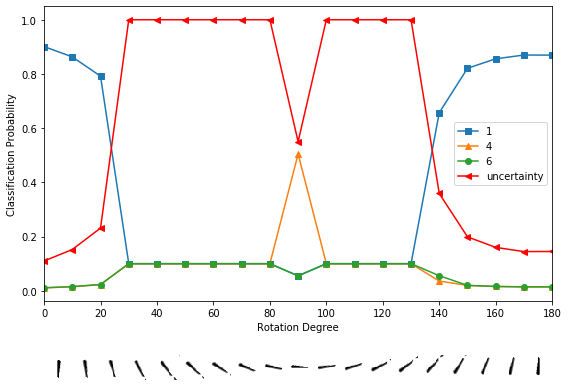

In [72]:
fig,axs = plt.subplots(2, 1, figsize=(8,6), gridspec_kw={'height_ratios': [3, 1]})

for i,m in zip(range_of(lbls),['s','^','o']*10): axs[0].plot(degs, lp[:,i], marker=m, label=lbls[i].item())
axs[0].plot(degs, u, marker='<', c='red', label='uncertainty')
axs[0].legend()
axs[0].set_xlim([0,180])  
axs[0].set_xlabel('Rotation Degree')
axs[0].set_ylabel('Classification Probability')

show_image(degs_img, ax=axs[1])
plt.tight_layout()

# ---